In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn import metrics

import statsmodels.api as sm
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

torch.manual_seed(42)

In [2]:
dataset = pd.read_csv("Data/BTC-USD.csv")
print(dataset.shape)
dataset.head()

(1827, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


Open The price of the coin at the beginning of the trading day. </br>

High: The highest price of the coin on a trading day. </br>

Low: The lowest price of the coin on a trading day. </br>

Close: The last price of the coin before the trading day ends. </br>

Volume is the amount of a token traded in a specific time interval. </br>

In [3]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,15208.247358,15629.267253,14746.920288,15231.832471,15231.832471,2.092230e+10
std,16829.476707,17296.796539,16289.465757,16838.811505,16838.811505,2.122934e+10
min,775.177979,823.307007,755.755981,777.757019,777.757019,6.085170e+07
25%,5308.327637,5422.169434,5221.697753,5319.541504,5319.541504,4.474525e+09
50%,8585.262695,8744.828125,8313.340820,8595.740234,8595.740234,1.607165e+10
75%,13500.216309,13852.566406,12921.156250,13548.505860,13548.505860,3.260844e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


#### Preprocessing

In [4]:
dataset["Close"].shape

(1827,)

In [5]:
dataset['pos_neg']= dataset['Open']-dataset['Close']
dataset.head()
#create a binary column - 0 = gain, 1 = loss to have something to predict
dataset['Up/Down'] = np.where(dataset['pos_neg']>0, '0', '1')

We checked if columns Close and Adj Close have the same records in order for Adj Close to be dropped.

In [6]:
(dataset["Close"] == dataset["Adj Close"]).sum()

1827

In [7]:
dataset["Date"]=pd.to_datetime(dataset['Date'])
dataset['Date']

0      2016-12-21
1      2016-12-22
2      2016-12-23
3      2016-12-24
4      2016-12-25
          ...    
1822   2021-12-17
1823   2021-12-18
1824   2021-12-19
1825   2021-12-20
1826   2021-12-21
Name: Date, Length: 1827, dtype: datetime64[ns]

In [8]:
dataset['Year'] = dataset['Date'].dt.year
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,pos_neg,Up/Down,Year
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000,-33.637024,1,2016
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008,-30.359985,1,2016
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000,-57.096009,1,2016
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008,23.357972,0,2016
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992,3.468995,0,2016
...,...,...,...,...,...,...,...,...,...,...
1822,2021-12-17,47653.730469,48004.894531,45618.214844,46202.144531,46202.144531,32902725329,1451.585938,0,2021
1823,2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,-629.523438,1,2021
1824,2021-12-19,46853.867188,48089.664063,46502.953125,46707.015625,46707.015625,25154053861,146.851563,0,2021
1825,2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,-173.214844,1,2021


#### Visualization

In [9]:
model = sm.formula.ols(formula= "Close ~ High + Low + Open", data= dataset)
multi_reg = model.fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.198e+06
Date:                Mon, 27 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:38:44   Log-Likelihood:                -13441.
No. Observations:                1827   AIC:                         2.689e+04
Df Residuals:                    1823   BIC:                         2.691e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6687     11.979      0.306      0.7

Based on the results of this model, we have a strong suspision of multicollinearity. 

Text(0.5, 1.0, 'Closing price trend')

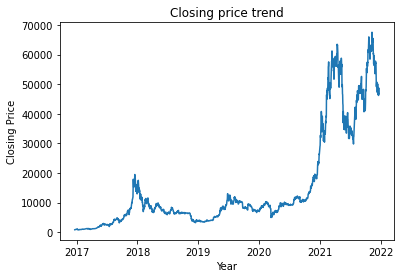

In [10]:
plt.plot('Date', 'Close', data=dataset)
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Closing price trend')

Text(0.5, 1.0, 'Volume trend')

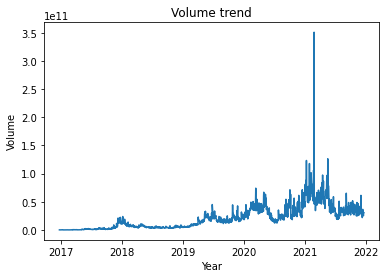

In [11]:
plt.plot('Date', 'Volume', data=dataset)
plt.xlabel('Year')
plt.ylabel('Volume')
plt.title('Volume trend')

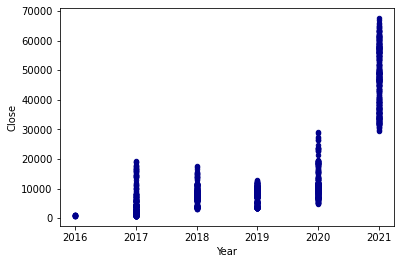

In [12]:
ax1 = dataset.plot.scatter(x='Year',
                      y='Close',
                      c='DarkBlue')

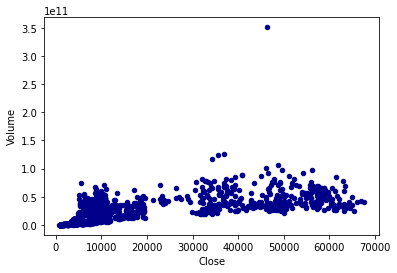

In [13]:
ax1 = dataset.plot.scatter(x='Close',
                      y='Volume',
                      c='DarkBlue')

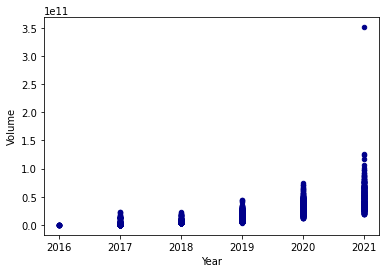

In [14]:
ax1 = dataset.plot.scatter(x='Year',
                      y='Volume',
                      c='DarkBlue')

#### Dataset scaling

In [15]:
scaled_data = dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = MinMaxScaler(copy=False)
scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_data

C:\Users\Μαρίνα Σαμ\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Open,High,Low,Close,Volume
0,0.000381,0.000161,0.000665,0.000846,0.000270
1,0.000884,0.000772,0.001195,0.001299,0.000397
2,0.001343,0.001498,0.001660,0.002159,0.000612
3,0.002201,0.001474,0.001990,0.001813,0.000219
4,0.001864,0.001123,0.001625,0.001773,0.000236
...,...,...,...,...,...
1822,0.702042,0.694191,0.683605,0.680117,0.093591
1823,0.680560,0.684023,0.683304,0.689799,0.074200
1824,0.690064,0.695438,0.697086,0.687676,0.071510
1825,0.687865,0.685316,0.683020,0.690270,0.088060


In [16]:
scaled_data["Up/Down"] = dataset["Up/Down"].copy()

C:\Users\DD7D~1\AppData\Local\Temp/ipykernel_15676/2909746662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data["Up/Down"] = dataset["Up/Down"].copy()


#### Linear Regression 

##### Training

In [17]:
X = scaled_data[['Open', 'High', 'Low', 'Volume']]
y = scaled_data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1278, 4)
(1278,)
(549, 4)
(549,)


In [18]:
linReg = LinearRegression()
linReg.fit(X_train, y_train)
print("Coefficients: \n", linReg.coef_)
print("Intercept: \n", linReg.intercept_)

Coefficients: 
 [-0.54594623  0.89860336  0.64917203 -0.00229671]
Intercept: 
 0.00032983741724930404


##### Testing

In [19]:
y_pred_lin = linReg.predict(X_test)
dfp = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': y_pred_lin})
dfp.head()

,Actual_Price,Predicted_Price
1278,0.127654,0.128212
1279,0.132821,0.131742
1280,0.132535,0.131644
1281,0.127803,0.129198
1282,0.127073,0.125493


##### Metrics

In [20]:
reg_score = linReg.score(X_test, y_test)
print("Linear Regression Score: ", reg_score)
print("Absolute Squared Error: ", mean_absolute_error(y_test, y_pred_lin))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred_lin))

Linear Regression Score:  0.9986702114127007
Absolute Squared Error:  0.006548516106754449
Mean Squared Error:  9.93455497730582e-05


In [21]:
dfp.describe()

,Actual_Price,Predicted_Price
count,549.000000,549.000000
mean,0.518665,0.518430
std,0.273577,0.273885
min,0.123787,0.123544
25%,0.210454,0.211550
50%,0.547075,0.543719
75%,0.737742,0.737600
max,1.000000,0.998454


In [22]:
y = linReg.coef_[0] * X_test['Open'] + linReg.coef_[1] * X_test['High'] + linReg.coef_[2] * X_test['Low'] + linReg.coef_[3] * X_test['Volume'] + linReg.intercept_
y

1278    0.128212
1279    0.131742
1280    0.131644
1281    0.129198
1282    0.125493
          ...   
1822    0.684417
1823    0.686857
1824    0.700880
1825    0.683815
1826    0.712986
Length: 549, dtype: float64

##### Plotting

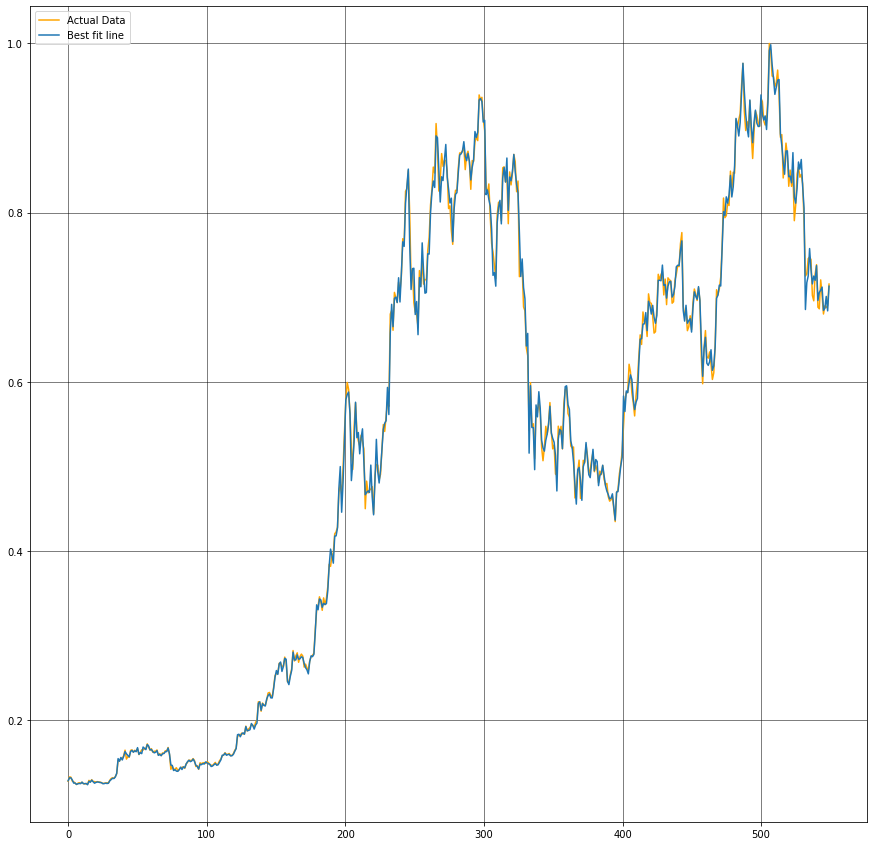

In [23]:
plt.subplots(1, figsize=(15, 15))
plt.plot(np.linspace(0, y_test.size, y_test.size), y_test, color='orange', label='Actual Data')
plt.plot(np.linspace(0, y_test.size, y_test.size), y, label='Best fit line')
plt.grid(color='#000000', linestyle='-', linewidth=0.5)
plt.legend(loc="upper left")

##### Scatter plot

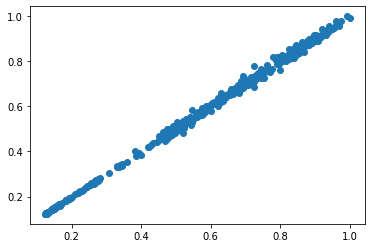

In [24]:
plt.scatter(dfp['Actual_Price'], dfp['Predicted_Price'])

#### Logistic Regression 

In [25]:
X = scaled_data[['Open', 'High', 'Low', 'Close','Volume']]
y = dataset["Up/Down"].values



##### Training

In [26]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

In [28]:
model1.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression())])

##### Metrics

In [29]:
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]

train_accuracy = accuracy_score(y_train, y_train_hat)
train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))

print('Training AUC: ' , train_auc_roc)

print('Training accuracy: ' , train_accuracy)

Confusion matrix:
 [[195 432]
 [ 10 733]]
Training AUC:  0.8661725278570218
Training accuracy:  0.6773722627737226


In [30]:
y_pred_log = model1.predict(X_test)
y_pred_log_probs = model1.predict_proba(X_test)[:,1]

test_accuracy = accuracy_score(y_test, y_pred_log)
test_auc_roc = roc_auc_score(y_test, y_pred_log_probs)

print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_log))

print('Testing AUC: ', test_auc_roc)

print('Testing accuracy: ' , test_accuracy) 

Confusion matrix:
 [[ 65 136]
 [  4 252]]
Testing AUC:  0.8605799129353233
Testing accuracy:  0.6936542669584245


In [31]:
print(classification_report(y_test, y_pred_log, digits=2))

              precision    recall  f1-score   support

           0       0.94      0.32      0.48       201
           1       0.65      0.98      0.78       256

    accuracy                           0.69       457
   macro avg       0.80      0.65      0.63       457
weighted avg       0.78      0.69      0.65       457



## Model Creation

In [32]:


# Get cpu or gpu device for training (If capable GPU present).
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} device available!")

class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(4, 50) # hidden layer
        self.hidden2 = torch.nn.Linear(50, 4) # hidden layer
        self.out = torch.nn.Linear(4, 1)     # output layer

    def forward(self, x):
        z = F.relu(self.hidden1(x)) # activation function for first hidden layer
        z = F.relu(self.hidden2(z)) # activation function for second hidden layer
        z = self.out(z)        # linear output
        return z

model = NeuralNetwork().to('cpu')
print(model)

cpu device available!
NeuralNetwork(
  (hidden1): Linear(in_features=4, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)


In [33]:
X = torch.Tensor(scaled_data[['Open', 'High', 'Low', 'Volume']].values)
y = torch.Tensor(scaled_data['Close'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1461, 4])
torch.Size([1461])
torch.Size([366, 4])
torch.Size([366])


##### Data Preperation

In [34]:
BATCH_SIZE = 50

train_dataset = Data.TensorDataset(X_train, y_train)
test_dataset = Data.TensorDataset(X_test, y_test)

train_loader = Data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

test_loader = Data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss() 

##### Training

In [35]:


EPOCH = 200
running_loss = 0.0

for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(train_loader): # for each training step
        
        optimizer.zero_grad()   # clear gradients for next train

        predictions = model(batch_x)           # input x and predict based on x
        loss = loss_func(predictions, batch_y)  # calculate MSE based on x and y
        loss.backward()                        # backpropagation, compute gradients
        optimizer.step()                       # apply gradients to weights

        # print statistics
        running_loss += loss.item()
        if step % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, running_loss / 2000))
            running_loss = 0.0

[1,    20] loss: 0.000
[2,    20] loss: 0.000


C:\Users\Μαρίνα Σαμ\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Μαρίνα Σαμ\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,    20] loss: 0.000
[4,    20] loss: 0.000
[5,    20] loss: 0.000
[6,    20] loss: 0.000
[7,    20] loss: 0.000
[8,    20] loss: 0.000
[9,    20] loss: 0.000
[10,    20] loss: 0.000
[11,    20] loss: 0.000
[12,    20] loss: 0.000
[13,    20] loss: 0.000
[14,    20] loss: 0.000
[15,    20] loss: 0.000
[16,    20] loss: 0.000
[17,    20] loss: 0.000
[18,    20] loss: 0.000
[19,    20] loss: 0.000
[20,    20] loss: 0.000
[21,    20] loss: 0.000
[22,    20] loss: 0.000
[23,    20] loss: 0.000
[24,    20] loss: 0.000
[25,    20] loss: 0.000
[26,    20] loss: 0.000
[27,    20] loss: 0.000
[28,    20] loss: 0.000
[29,    20] loss: 0.000
[30,    20] loss: 0.000
[31,    20] loss: 0.000
[32,    20] loss: 0.000
[33,    20] loss: 0.000
[34,    20] loss: 0.000
[35,    20] loss: 0.000
[36,    20] loss: 0.000
[37,    20] loss: 0.000
[38,    20] loss: 0.000
[39,    20] loss: 0.000
[40,    20] loss: 0.000
[41,    20] loss: 0.000
[42,    20] loss: 0.000
[43,    20] loss: 0.000
[44,    20] loss: 0.000

##### Testing